## CIFAR10 Experiments
- Step 1: Set-up
- Step 2: Load data
- Step 3: Image classification using ResNet18 with different optimizers using default parameters
- Step 4: Hyperparameter tuning
- Step 5: Tuned performance and analysis of importance of tunining for optmizers
- Step 6: Plot results

################################# ATTENTION ############################################

If the user does not want to run the full training/testing, he/she can run Step 1 and then move to Step 6 to plot the results.

################################# ATTENTION ############################################

#### Step 1: Set-up

In [1]:
! pip install madgrad
! pip install adabelief-pytorch==0.2.0
! pip install optuna

You should consider upgrading via the 'c:\users\lucaz\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\lucaz\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\lucaz\anaconda3\python.exe -m pip install --upgrade pip' command.


Import libraries

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from adabelief_pytorch import AdaBelief
from madgrad import MADGRAD
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import pickle

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# torch.cuda.get_device_name(0)

### Step 2: Load data

In [6]:
# Set it to True if you want to run the cross_validation
validation = False

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset= torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
if validation:
    trainset, valset = torch.utils.data.random_split(trainset, [45000, 5000])
    valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testset= torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


### Step 3: Image classification default parameters
Run the training and get the results for each optimizer using 5 different seeds. The results are then plotted using the mean and standard deviation.

In [ ]:
def get_results(optimizer_name = 'sgd'):
    for i in range(5):
        # Measure the running time to have a reference
        start_time = time.time()
        #set the seed
        torch.manual_seed(i)
        #initialize the model and loss
        model = models.resnet18()
        criterion = nn.CrossEntropyLoss()
        # Uncomment the line optimizer you want to test
        if optimizer_name == 'adabelief':
            optimizer = AdaBelief(model.parameters(), lr=0.001, betas=(0.9,0.999), eps=1e-16, weight_decouple=False, rectify=False) #fixed_decay=False, amsgrad=False, weight_decay=5e-4
        if optimizer_name == 'madgrad':
            optimizer = MADGRAD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0, eps=1e-6, decouple_decay=False)
        if optimizer_name == "adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        if optimizer_name == "sgd":
            optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

        # Train the model for image classification
        model.to(device)
        num_epochs = 100
        total_step = len(trainloader)
        loss_trial = []
        acc_trial = []
        for epoch in range(num_epochs):
            total_loss = 0
            model.train()
            for j, (images, labels) in enumerate(trainloader):
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (j+1) % 100 == 0:
                    print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                          .format(epoch+1, num_epochs, j+1, total_step, loss.item()))
            loss_trial.append(total_loss/total_step)
            # Test the model
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in testloader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            acc_trial.append(100 * correct / total)
        train_time = time.time() - start_time
        print(train_time)
        np.save('results_data/{}_cifar/loss_resnet18_{}_episode_{}.npy'.format(optimizer_name, optimizer_name, i), loss_trial)
        np.save('results_data/{}_cifar/acc_resnet18_{}_episode_{}.npy'.format(optimizer_name, optimizer_name, i), acc_trial)
        print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

0
Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Epoch [1/100], Step [100/391] Loss: 3.9122
Epoch [1/100], Step [200/391] Loss: 3.6655
Epoch [1/100], Step [300/391]

In [ ]:
# Run the experiments (THIS RUNS FOR LONG!!)
get_results(optimizer_name = 'sgd')
get_results(optimizer_name = 'adam')
get_results(optimizer_name = 'adabelief')
get_results(optimizer_name = 'madgrad')

We also experimented with a combined version of AdaBelief and Madgrad

In [ ]:
# Run the training 5 times
for i in range(5):
    start_time = time.time()
    torch.manual_seed(i)

    # Define the ResNet18 model
    model = models.resnet18()

    # Define the loss
    criterion = nn.CrossEntropyLoss()

    # Hyper-parameter for the switching time
    T = 26

    # Configure the optimizer with default hyperparameters
    optimizer = MADGRAD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0, eps=1e-6, decouple_decay=False)

    model.to(device)
    num_epochs = 100
    total_step = len(trainloader)
    loss_trial = []
    acc_trial = []

    # Train the model
    for epoch in range(num_epochs):

        # Check if we switch the optimizer to AdaBelief
        if epoch == T :
            optimizer = AdaBelief(model.parameters(), lr=0.001, betas=(0.9,0.999), eps=1e-16, weight_decouple=False, rectify=False)

        total_loss = 0
        model.train()

        # Training for one epoch
        for j, (images, labels) in enumerate(trainloader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Set the parameter gradients to zero
            optimizer.zero_grad()

            # Backward and optimize
            loss.backward()
            optimizer.step()

        print ("Epoch {}/{}, Loss: {:.4f}"
                      .format(epoch+1, num_epochs, loss.item()))

        # Store the loss at the end of the epoch
        loss_trial.append(total_loss/total_step)

        # Test the model at the end of each epoch
        model.eval()
        with torch.no_grad():

            # Count the number of good predictions
            correct = 0
            total = 0
            for images, labels in testloader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                # Check if the prediction matches the exact label value
                correct += (predicted == labels).sum().item()

        # Store the accuracy at the end of the epoch
        acc_trial.append(100 * correct/total)

    # Total time for the training
    train_time = time.time() - start_time

    # Print relevant results
    print(train_time)
    print('Accuracy on the test images: {} %'.format(100 * correct / total))
    print(loss_trial[-1])

    # Save the results externally
    np.save('results_data/mix_cifar/loss_resnet18_combined_T{}_episode_{}.npy'.format(T, i), loss_trial)
    np.save('results_data/mix_cifar/acc_resnet18_combined_T{}_episode_{}.npy'.format(T, i), acc_trial)

#### Step 4: Hyperparameter tuning
We now perform hyperparameter tuning to see the performance of the optimizers after being tuned

In [ ]:
def cross_validation_cifar(model, criterion, optimizer):
    for e in range(30):
        total_loss = 0
        model.train()
        for j, (images, labels) in enumerate(trainloader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Test the model
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in valloader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [ ]:
def initialize_validation_cifar(model, parameters, optim='Adam'):
    if optim == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), betas=(parameters['momentum'], parameters['beta2']), lr=parameters['learning_rate'], weight_decay=parameters['weight_decay'])
    elif optim == "Madgrad":
        optimizer = MADGRAD(model.parameters(), lr=parameters['learning_rate'], weight_decay=parameters['weight_decay'], momentum=parameters['momentum'])
    elif optim == "AdaBelief":
        optimizer = AdaBelief(model.parameters(), lr=parameters['learning_rate'], eps=1e-8, weight_decay=parameters['weight_decay'], betas=(parameters['momentum'], parameters['beta2']), weight_decouple = False, rectify = False)
    elif optim == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=parameters['learning_rate'], weight_decay=parameters['weight_decay'], momentum=parameters['momentum'])

    val_acc  = cross_validation_cifar(model, nn.CrossEntropyLoss(), optimizer)

    return val_acc

In [ ]:
"""Hyperparameter tuning SGD: Optuna"""
def objective_cifar(trial):
    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'momentum': trial.suggest_loguniform('momentum', 0.7, 0.999),
              'weight_decay': trial.suggest_loguniform('weight_decay', 1e-9, 1e-3)
              }

    model = models.resnet18()
    model.to(device)

    val_acc = initialize_validation_cifar(model, params, "SGD")
    return val_acc

study = optuna.create_study(study_name='sgd', direction="maximize", sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective_cifar, n_trials=5)
with open('hyperparameter_tuning_cifar/CIFAR10_sgd.pkl', 'wb') as f:
    pickle.dump(study, f)
# Split because we ran on Colab and we needed to store results frequently
for j in range(9):
  with open("hyperparameter_tuning_cifar/CIFAR10_sgd.pkl", "rb") as input_file:
    study = pickle.load(input_file)
  study.optimize(objective_cifar, n_trials=5)
  with open("hyperparameter_tuning_cifar/CIFAR10_sgd.pkl", "wb") as f:
    pickle.dump(study, f)

In [ ]:
"""Hyperparameter tuning SGD: Optuna"""
def objective_cifar(trial):
    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'momentum': trial.suggest_loguniform('momentum', 0.7, 0.999),
              'beta2': trial.suggest_loguniform('beta2', 0.7, 0.999),
              'weight_decay': trial.suggest_loguniform('weight_decay', 1e-9, 1e-3)
              }

    model = models.resnet18()
    model.to(device)

    val_acc = initialize_validation_cifar(model, params, "Adam")
    return val_acc

study = optuna.create_study(study_name='adam', direction="maximize", sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective_cifar, n_trials=5)
with open('hyperparameter_tuning_cifar/CIFAR10_adam.pkl', 'wb') as f:
    pickle.dump(study, f)
# Split because we ran on Colab and we needed to store results frequently
for j in range(9):
  with open("hyperparameter_tuning_cifar/CIFAR10_adam.pkl", "rb") as input_file:
    study = pickle.load(input_file)
  study.optimize(objective_cifar, n_trials=5)
  with open("hyperparameter_tuning_cifar/CIFAR10_adam.pkl", "wb") as f:
    pickle.dump(study, f)

In [ ]:
"""Hyperparameter tuning SGD: Optuna"""
def objective_cifar(trial):
    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'momentum': trial.suggest_loguniform('momentum', 0.7, 0.999),
              'weight_decay': trial.suggest_loguniform('weight_decay', 1e-9, 1e-3)
              }

    model = models.resnet18()
    model.to(device)

    val_acc = initialize_validation_cifar(model, params, "Madgrad")
    return val_acc

study = optuna.create_study(study_name='madgrad', direction="maximize", sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective_cifar, n_trials=5)
with open('hyperparameter_tuning_cifar/CIFAR10_madgrad.pkl', 'wb') as f:
    pickle.dump(study, f)
# Split because we ran on Colab and we needed to store results frequently
for j in range(9):
  with open("hyperparameter_tuning_cifar/CIFAR10_madgrad.pkl", "rb") as input_file:
    study = pickle.load(input_file)
  study.optimize(objective_cifar, n_trials=5)
  with open("hyperparameter_tuning_cifar/CIFAR10_madgrad.pkl", "wb") as f:
    pickle.dump(study, f)

In [ ]:
"""Hyperparameter tuning SGD: Optuna"""
def objective_cifar(trial):
    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'momentum': trial.suggest_loguniform('momentum', 0.7, 0.999),
              'beta2': trial.suggest_loguniform('beta2', 0.7, 0.999),
              'weight_decay': trial.suggest_loguniform('weight_decay', 1e-9, 1e-3)
              }

    model = models.resnet18()
    model.to(device)

    val_acc = initialize_validation_cifar(model, params, "AdaBelief")
    return val_acc

study = optuna.create_study(study_name='adabelief', direction="maximize", sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective_cifar, n_trials=5)
with open('hyperparameter_tuning_cifar/CIFAR10_adabelief.pkl', 'wb') as f:
    pickle.dump(study, f)
# Split because we ran on Colab and we needed to store results frequently
for j in range(9):
  with open("hyperparameter_tuning_cifar/CIFAR10_adabelief.pkl", "rb") as input_file:
    study = pickle.load(input_file)
  study.optimize(objective_cifar, n_trials=5)
  with open("hyperparameter_tuning_cifar/CIFAR10_adabelief.pkl", "wb") as f:
    pickle.dump(study, f)

### Step 5: Get tuned performance
The parameters used are those that gave the best validation accuracy in the tunining phase

In [ ]:
def get_results_tuned(optimizer_name = 'sgd'):
    for i in range(5):
        # Measure the running time to have a reference
        start_time = time.time()
        #set the seed
        torch.manual_seed(i)
        #initialize the model and loss
        model = models.resnet18()
        criterion = nn.CrossEntropyLoss()
        # Uncomment the line optimizer you want to test
        if optimizer_name == 'adabelief':
            optimizer = AdaBelief(model.parameters(), lr=0.0022623929634425885, betas=(0.8183373969429426,0.7427364778206769), eps=1e-16, weight_decay=7.183812824348907e-07, weight_decouple=False, rectify=False) #fixed_decay=False, amsgrad=False, weight_decay=5e-4
        if optimizer_name == 'madgrad':
            optimizer = MADGRAD(model.parameters(), lr=0.001871450068624067, momentum=0.9729098286644504, weight_decay=2.6681875242370476e-09, eps=1e-6, decouple_decay=False)
        if optimizer_name == "adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=0.0022198389789008445, betas=(0.7745169535451423, 0.8456690094431321), eps=1e-08, weight_decay=0.00010048897807562723, amsgrad=False)
        if optimizer_name == "sgd":
            optimizer = torch.optim.SGD(model.parameters(), lr=0.06399715453910407, momentum=0.7746263625752962, weight_decay=1.730071019154968e-07)

        # Train the model for image classification
        model.to(device)
        num_epochs = 100
        total_step = len(trainloader)
        loss_trial = []
        acc_trial = []
        for epoch in range(num_epochs):
            total_loss = 0
            model.train()
            for j, (images, labels) in enumerate(trainloader):
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (j+1) % 100 == 0:
                    print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                          .format(epoch+1, num_epochs, j+1, total_step, loss.item()))
            loss_trial.append(total_loss/total_step)
            # Test the model
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in testloader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            acc_trial.append(100 * correct / total)
        train_time = time.time() - start_time
        print(train_time)
        np.save('results_data/{}_best_cifar/loss_resnet18_best_{}_episode_{}.npy'.format(optimizer_name, optimizer_name, i), loss_trial)
        np.save('results_data/{}_best_cifar/acc_resnet18_best_{}_episode_{}.npy'.format(optimizer_name, optimizer_name, i), acc_trial)
        print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

In [ ]:
# Run the experiments (THIS RUNS FOR LONG!!)
get_results_tuned(optimizer_name = 'sgd')
get_results_tuned(optimizer_name = 'adam')
get_results_tuned(optimizer_name = 'adabelief')
get_results_tuned(optimizer_name = 'madgrad')

### Step 6: Plot the results
Plot results with default parameters

In [15]:
def construct_dataframe_results(output = 'loss'):
    adabelief = np.zeros((5, 100))
    for i in range(5):
        adabelief[i, :] = np.load('results_data/adabelief_cifar/{}_resnet18_adabelief_episode_{}.npy'.format(output, i))

    madgrad = np.zeros((5, 100))
    for i in range(5):
        madgrad[i, :] = np.load('results_data/madgrad_cifar/{}_resnet18_madgrad_episode_{}.npy'.format(output, i))

    adam = np.zeros((5, 100))
    for i in range(5):
        adam[i, :] = np.load('results_data/adam_cifar/{}_resnet18_adam_episode_{}.npy'.format(output, i))

    sgd = np.zeros((5, 100))
    for i in range(5):
        sgd[i, :] = np.load('results_data/sgd_cifar/{}_resnet18_sgd_episode_{}.npy'.format(output, i))

    mixed = np.zeros((5, 100))
    for i in range(5):
        mixed[i, :] = np.load('results_data/mix_cifar/{}_resnet18_combined_T26_episode_{}.npy'.format(output, i))

    epochs = [i for i in range(100)]
    epochs = epochs + epochs + epochs+ epochs+ epochs
    observations = [i for i in range(5) for j in range(100)]
    adabelief_pd = pd.DataFrame(np.column_stack((adabelief.flatten(),np.array(epochs), np.array(observations))),columns = [output, 'epoch', 'trial'])
    adabelief_pd['optimizer'] = "adabelief"
    madgrad_pd = pd.DataFrame(np.column_stack((madgrad.flatten(),np.array(epochs), np.array(observations))),columns = [output, 'epoch', 'trial'])
    madgrad_pd['optimizer'] = "madgrad"
    adam_pd = pd.DataFrame(np.column_stack((adam.flatten(),np.array(epochs), np.array(observations))),columns = [output, 'epoch', 'trial'])
    adam_pd['optimizer'] = "adam"
    sgd_pd = pd.DataFrame(np.column_stack((sgd.flatten(),np.array(epochs), np.array(observations))),columns = [output, 'epoch', 'trial'])
    sgd_pd['optimizer'] = "sgd momentum"
    mixed_pd = pd.DataFrame(np.column_stack((mixed.flatten(),np.array(epochs), np.array(observations))),columns = [output, 'epoch', 'trial'])
    mixed_pd['optimizer'] = "adabelief + madgrad"

    frames = [adabelief_pd, madgrad_pd, adam_pd, sgd_pd]#, mixed_pd]
    return pd.concat(frames)

Text(0.5, 0, 'Epoch')

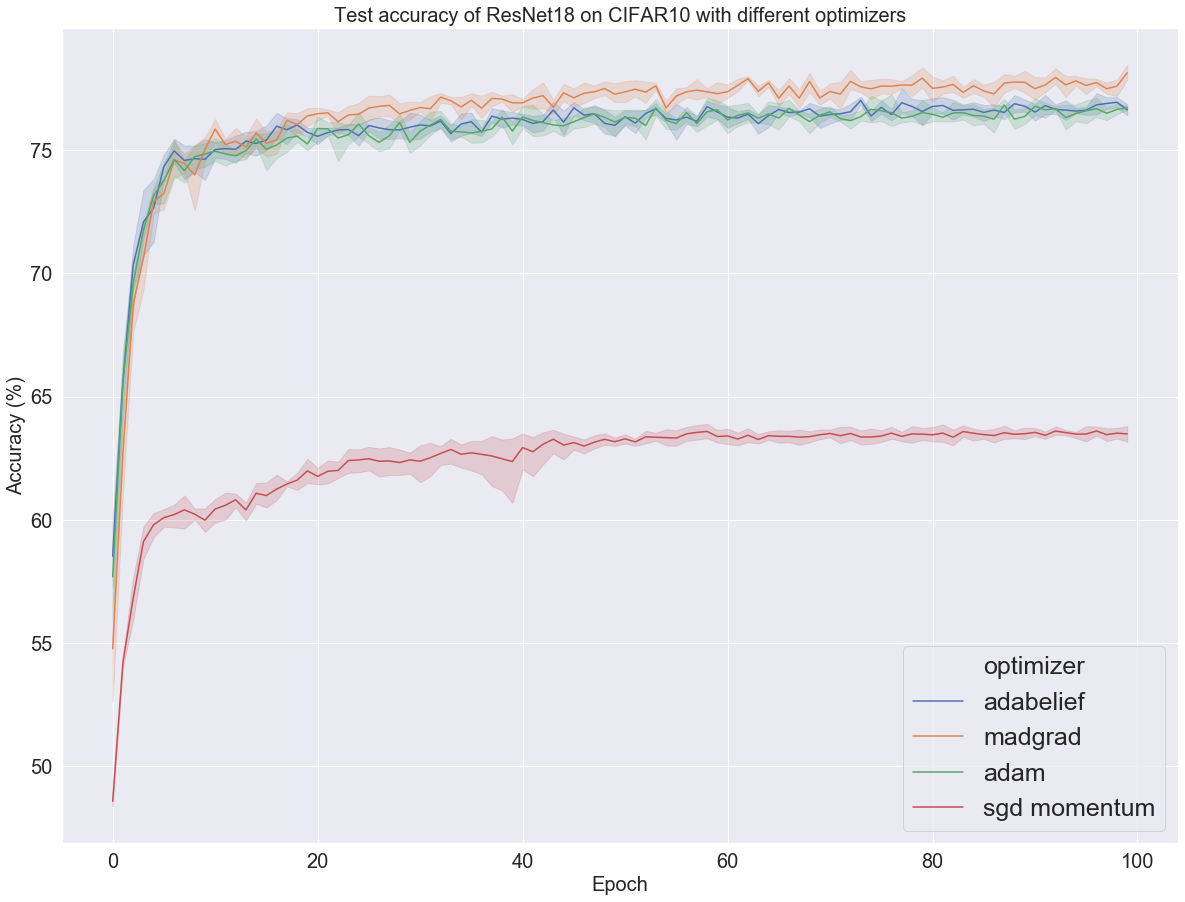

In [16]:
# Plot accuracies
sns.set(rc={'figure.figsize':(20,15)})
sns.lineplot(data=construct_dataframe_results('acc'), x='epoch', y='acc', hue='optimizer')
plt.legend(fontsize='25', title_fontsize='50')
plt.title('Test accuracy of ResNet18 on CIFAR10 with different optimizers', fontsize=20)
plt.ylabel('Accuracy (%)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Epoch', fontsize=20)

Text(0.5, 0, 'Epoch')

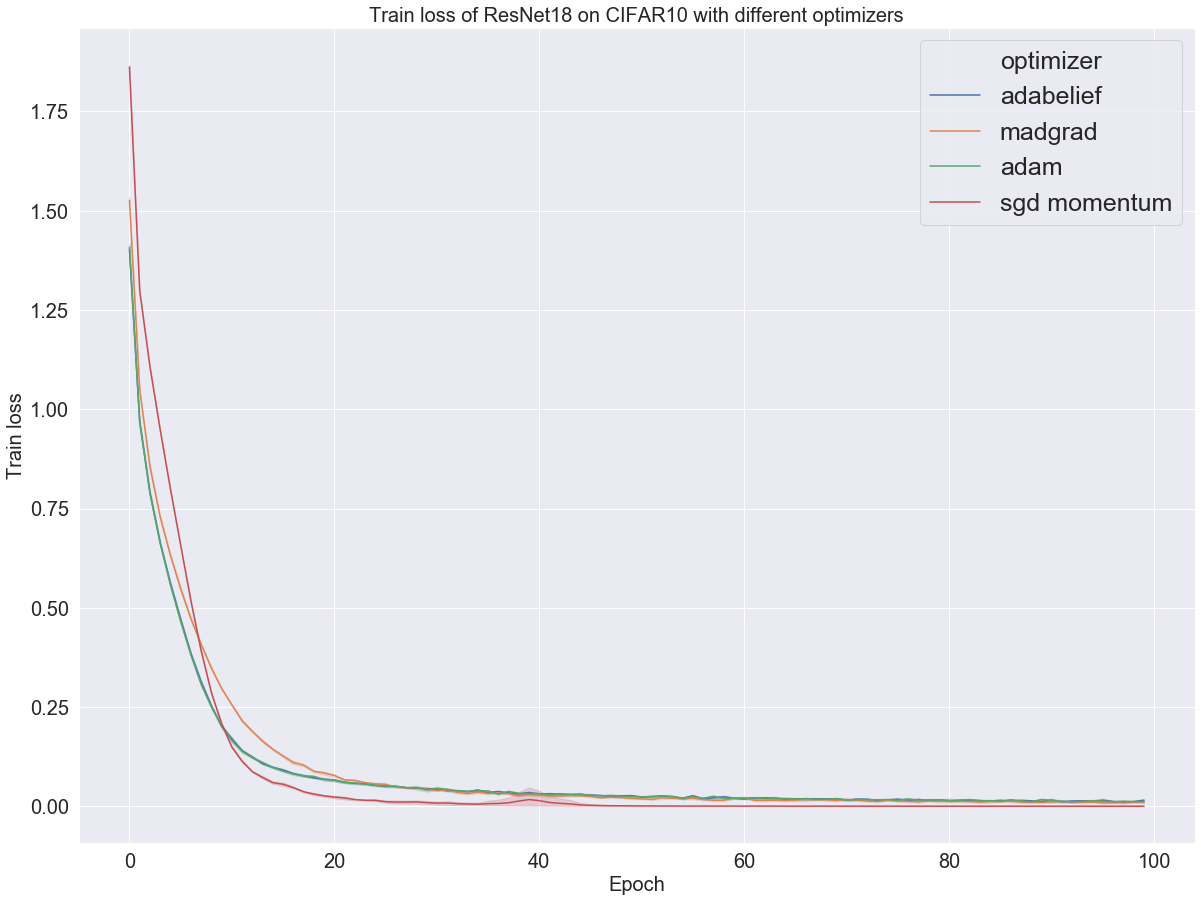

In [10]:
# Plot losses
sns.set(rc={'figure.figsize':(20,15)})
sns.lineplot(data=construct_dataframe_results('loss'), x='epoch', y='loss', hue='optimizer')
plt.legend(fontsize='25', title_fontsize='50')
plt.title('Train loss of ResNet18 on CIFAR10 with different optimizers', fontsize=20)
plt.ylabel('Train loss', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Epoch', fontsize=20)

Plot tuned performance

In [7]:
def construct_dataframe_tuned_results(output = 'loss'):
    adabelief = np.zeros((5, 100))
    for i in range(5):
        adabelief[i, :] = np.load('results_data/adabelief_best_cifar/{}_resnet18_adabelief_episode_{}.npy'.format(output, i))

    madgrad = np.zeros((5, 100))
    for i in range(5):
        madgrad[i, :] = np.load('results_data/madgrad_best_cifar/{}_resnet18_madgrad_episode_{}.npy'.format(output, i))

    adam = np.zeros((5, 100))
    for i in range(5):
        adam[i, :] = np.load('results_data/adam_best_cifar/{}_resnet18_adam_episode_{}.npy'.format(output, i))

    sgd = np.zeros((5, 100))
    for i in range(5):
        sgd[i, :] = np.load('results_data/sgd_best_cifar/{}_resnet18_sgd_episode_{}.npy'.format(output, i))

    epochs = [i for i in range(100)]
    epochs = epochs + epochs + epochs+ epochs+ epochs
    observations = [i for i in range(5) for j in range(100)]
    adabelief_pd = pd.DataFrame(np.column_stack((adabelief.flatten(),np.array(epochs), np.array(observations))),columns = [output, 'epoch', 'trial'])
    adabelief_pd['optimizer'] = "adabelief"
    madgrad_pd = pd.DataFrame(np.column_stack((madgrad.flatten(),np.array(epochs), np.array(observations))),columns = [output, 'epoch', 'trial'])
    madgrad_pd['optimizer'] = "madgrad"
    adam_pd = pd.DataFrame(np.column_stack((adam.flatten(),np.array(epochs), np.array(observations))),columns = [output, 'epoch', 'trial'])
    adam_pd['optimizer'] = "adam"
    sgd_pd = pd.DataFrame(np.column_stack((sgd.flatten(),np.array(epochs), np.array(observations))),columns = [output, 'epoch', 'trial'])
    sgd_pd['optimizer'] = "sgd momentum"

    frames = [adabelief_pd, madgrad_pd, adam_pd, sgd_pd]
    return pd.concat(frames)

In [8]:
# Plot accuracies
sns.set(rc={'figure.figsize':(20,15)})
sns.lineplot(data=construct_dataframe_tuned_results('acc'), x='epoch', y='acc', hue='optimizer')
plt.legend(fontsize='25', title_fontsize='50')
plt.title('Test accuracy of ResNet18 on CIFAR10 with tuned optimizers', fontsize=20)
plt.ylabel('Accuracy (%)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Epoch', fontsize=20)

FileNotFoundError: [Errno 2] No such file or directory: 'adabelief_best_cifar/acc_resnet18_adabelief_episode_0.npy'

In [ ]:
# Plot losses
sns.set(rc={'figure.figsize':(20,15)})
sns.lineplot(data=construct_dataframe_tuned_results('loss'), x='epoch', y='loss', hue='optimizer')
plt.legend(fontsize='25', title_fontsize='50')
plt.title('Train loss of ResNet18 on CIFAR10 with tuned optimizers', fontsize=20)
plt.ylabel('Train loss', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Epoch', fontsize=20)

### Difference due to tuning

In [ ]:
def construct_dataframe_difference(output = 'loss'):
    adabelief = np.zeros((5, 50))
    for i in range(5):
        adabelief[i, :] = np.subtract(np.load('results_data/adabelief_cifar/{}_resnet18_adabelief_episode_{}.npy'.format(output, i)),
                                      np.load('results_data/adabelief_best_cifar/{}_resnet18_adabelief_episode_{}.npy'.format(output, i)))

    madgrad = np.zeros((5, 50))
    for i in range(5):
        madgrad[i, :] = np.subtract(np.load('results_data/madgrad_cifar/{}_resnet18_madgrad_episode_{}.npy'.format(output, i)),
                                      np.load('results_data/madgrad_best_cifar/{}_resnet18_madgrad_episode_{}.npy'.format(output, i)))

    adam = np.zeros((5, 50))
    for i in range(5):
        adam[i, :] = np.subtract(np.load('results_data/adam_best_cifar/{}_resnet18_adam_episode_{}.npy'.format(output, i)),
                                      np.load('results_data/adam_best_cifar/{}_resnet18_adam_episode_{}.npy'.format(output, i)))

    sgd = np.zeros((5, 50))
    for i in range(3):
        sgd[i, :] = np.subtract(np.load('results_data/sgd_best_cifar/{}_resnet18_sgd_episode_{}.npy'.format(output, i)),
                                      np.load('results_data/sgd_best_cifar/{}_resnet18_sgd_episode_{}.npy'.format(output, i)))

    epochs = [i for i in range(50)]
    epochs = epochs + epochs + epochs + epochs + epochs
    observations = [i for i in range(5) for j in range(50)]
    adabelief_pd = pd.DataFrame(np.column_stack((adabelief.flatten(), np.array(epochs), np.array(observations))),
                                columns=[output, 'epoch', 'trial'])
    adabelief_pd['optimizer'] = "adabelief"
    madgrad_pd = pd.DataFrame(np.column_stack((madgrad.flatten(), np.array(epochs), np.array(observations))),
                              columns=[output, 'epoch', 'trial'])
    madgrad_pd['optimizer'] = "madgrad"
    adam_pd = pd.DataFrame(np.column_stack((adam.flatten(), np.array(epochs), np.array(observations))),
                           columns=[output, 'epoch', 'trial'])
    adam_pd['optimizer'] = "adam"
    sgd_pd = pd.DataFrame(np.column_stack((sgd.flatten(), np.array(epochs), np.array(observations))),
                          columns=[output, 'epoch', 'trial'])
    sgd_pd['optimizer'] = "sgd momentum"
    frames = [adabelief_pd, madgrad_pd, adam_pd, sgd_pd]
    return pd.concat(frames)

In [ ]:
# Plot accuracy difference
sns.set(rc={'figure.figsize':(20,15)})
sns.lineplot(data=construct_dataframe_difference('acc'), x='epoch', y='acc', hue='optimizer')
plt.legend(fontsize='25', title_fontsize='50')
plt.title('Difference Test accuracy between default and tuned optimizers', fontsize=20)
plt.ylabel('Accuracy difference (%)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Epoch', fontsize=20)

In [ ]:
# Plot loss difference
sns.set(rc={'figure.figsize':(20,15)})
sns.lineplot(data=construct_dataframe_difference('loss'), x='epoch', y='loss', hue='optimizer')
plt.legend(fontsize='25', title_fontsize='50')
plt.title('Difference Training loss between default and tuned optimizers', fontsize=20)
plt.ylabel('Loss difference', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Epoch', fontsize=20)